In [1]:
import numpy as np
import torch
import uproot
import h5py
from torch_geometric.data import Data
import os

# Configuration
features = ['Jet.PT', 'Jet.Eta', 'Jet.Phi', 'Jet.Mass', 'Jet.NCharged']
signal_file = '13TeV_signal.root'
background_file = '13TeV_BKG.root'
tree_name = 'Delphes'
output_h5_file = 'graph_data.h5'

def load_data(file_path, label):
    """Load ROOT file and create PyG Data objects"""
    file = uproot.open(file_path)
    tree = file[tree_name]
    data_list = []
    
    # Load all events as a dictionary of arrays
    jets = tree.arrays(features, library='np')
    
    # Get number of events
    num_events = len(jets[features[0]])
    
    for i in range(num_events):
        event_data = []
        for feat in features:
            feat_values = jets[feat][i]
            event_data.append(feat_values)
        
        # Create feature matrix (num_jets × num_features)
        x = np.column_stack(event_data)
        x = np.nan_to_num(x)
        num_nodes = x.shape[0]
        if num_nodes == 0:
            continue  # skip empty events
        
        # Create fully connected edge index
        edge_index = []
        for i_node in range(num_nodes):
            for j_node in range(num_nodes):
                edge_index.append([i_node, j_node])
        edge_index = np.array(edge_index).T  # Shape: [2, num_edges]
        
        # Store each event as a dictionary
        event_dict = {
            'x': x,  # node features
            'edge_index': edge_index,
            'y': label,
            'num_nodes': num_nodes
        }
        data_list.append(event_dict)
    
    return data_list

# ---- Load Data ----
signal_data = load_data(signal_file, label=1)
background_data = load_data(background_file, label=0)

# Combine datasets
dataset = signal_data + background_data
np.random.shuffle(dataset)

# ---- Write to HDF5 File ----
with h5py.File(output_h5_file, 'w') as h5f:
    for i, event in enumerate(dataset):
        grp = h5f.create_group(f'event_{i}')
        grp.create_dataset('x', data=event['x'])
        grp.create_dataset('edge_index', data=event['edge_index'])
        grp.create_dataset('y', data=np.array([event['y']]))
        grp.attrs['num_nodes'] = event['num_nodes']

print(f"Saved {len(dataset)} events to {output_h5_file}")


Saved 1999 events to graph_data.h5


visualize graph_data

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

# Open the HDF5 file
with h5py.File('graph_data.h5', 'r') as h5f:
    # List all event groups
    print("Available events:", list(h5f.keys()))
    
    # Choose an event to inspect (say event_0)
    event_key = 'event_0'
    grp = h5f[event_key]
    
    # Load data
    x = grp['x'][:]  # Node features
    edge_index = grp['edge_index'][:]
    y = grp['y'][0]  # Label (0 = background, 1 = signal)
    num_nodes = grp.attrs['num_nodes']
    
    print(f"Event: {event_key}")
    print(f"Number of nodes (jets): {num_nodes}")
    print(f"Node features shape: {x.shape}")  # Should be [num_nodes, num_features]
    print(f"Edge index shape: {edge_index.shape}")  # [2, num_edges]
    print(f"Label: {y}")
    
    # Optional: Print first few node features
    print("First few jet features:")
    print(x[:5])



Available events: ['event_0', 'event_1', 'event_10', 'event_100', 'event_1000', 'event_1001', 'event_1002', 'event_1003', 'event_1004', 'event_1005', 'event_1006', 'event_1007', 'event_1008', 'event_1009', 'event_101', 'event_1010', 'event_1011', 'event_1012', 'event_1013', 'event_1014', 'event_1015', 'event_1016', 'event_1017', 'event_1018', 'event_1019', 'event_102', 'event_1020', 'event_1021', 'event_1022', 'event_1023', 'event_1024', 'event_1025', 'event_1026', 'event_1027', 'event_1028', 'event_1029', 'event_103', 'event_1030', 'event_1031', 'event_1032', 'event_1033', 'event_1034', 'event_1035', 'event_1036', 'event_1037', 'event_1038', 'event_1039', 'event_104', 'event_1040', 'event_1041', 'event_1042', 'event_1043', 'event_1044', 'event_1045', 'event_1046', 'event_1047', 'event_1048', 'event_1049', 'event_105', 'event_1050', 'event_1051', 'event_1052', 'event_1053', 'event_1054', 'event_1055', 'event_1056', 'event_1057', 'event_1058', 'event_1059', 'event_106', 'event_1060', 'e

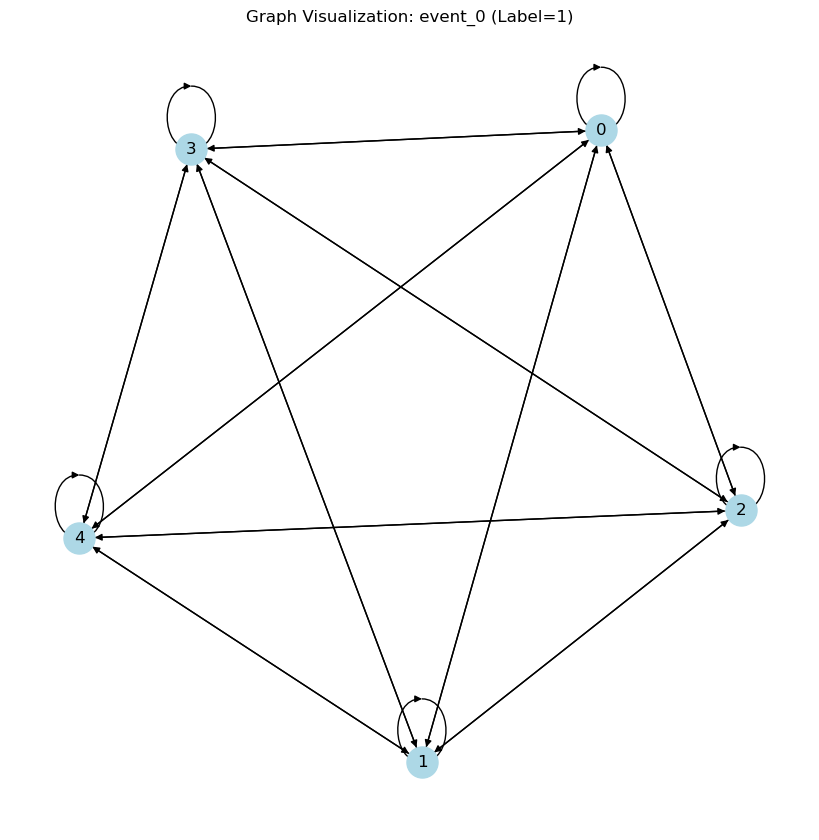

In [3]:
# Create NetworkX graph
G = nx.DiGraph()  # Directed graph (since edges are ordered)

# Add nodes with features
for i in range(num_nodes):
    G.add_node(i, feature=x[i])

# Add edges
edges = list(zip(edge_index[0], edge_index[1]))
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G)  # or any other layout
nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', arrows=True)
plt.title(f"Graph Visualization: {event_key} (Label={y})")
plt.show()


In [4]:
import torch
from torch_geometric.data import Data

# Convert to torch tensors
x_tensor = torch.tensor(x, dtype=torch.float)
edge_index_tensor = torch.tensor(edge_index, dtype=torch.long)
y_tensor = torch.tensor([y], dtype=torch.float)

# Create PyG Data object
data = Data(x=x_tensor, edge_index=edge_index_tensor, y=y_tensor)

print(data)


Data(x=[5, 5], edge_index=[2, 25], y=[1])
